In [ ]:
install.packages("reshape2")
install.packages("VIM")
install.packages("dplyr")
install.packages("ggplot2")
install.packages("caret")
install.packages("corrplot")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘plyr’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘cowplot’, ‘Deriv’, ‘microbenchmark’, ‘numDeriv’, ‘doBy’, ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘zoo’, ‘carData’, ‘abind’, ‘Formula’, ‘pbkrtest’, ‘quantreg’, ‘lme4’, ‘DEoptimR’, ‘lmtest’, ‘proxy’, ‘RcppEigen’, ‘car’, ‘robustbase’, ‘sp’, ‘vcd’, ‘e1071’, ‘laeken’, ‘ranger’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘foreach’

In [ ]:
# Load Required Libraries
library(dplyr)
library(ggplot2)
library(caret)
library(VIM)
library(corrplot)




Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: lattice

Loading required package: colorspace

Loading required package: grid

VIM is ready to use.


Suggestions and bug-reports can be submitted at: https://github.com/statistikat/VIM/issues


Attaching package: ‘VIM’


The following object is masked from ‘package:datasets’:

    sleep


corrplot 0.95 loaded



In [ ]:
train_data <- read.csv("train.csv")

In [ ]:
dim(train_data)

[1] 1460   81

In [ ]:
# Step 1: Separate the Target Variable
response_variable <- "SalePrice"
target <- train_data$SalePrice
train_data_no_target <- train_data %>% select(-c(Id, SalePrice))
dim(train_data_no_target)

[1] 1460   79

In [ ]:
# Step 2: Analyze Missing Values
missing_values <- sum(is.na(train_data_no_target))
cat("Number of missing values:", missing_values, "\n")


Number of missing values: 6965 


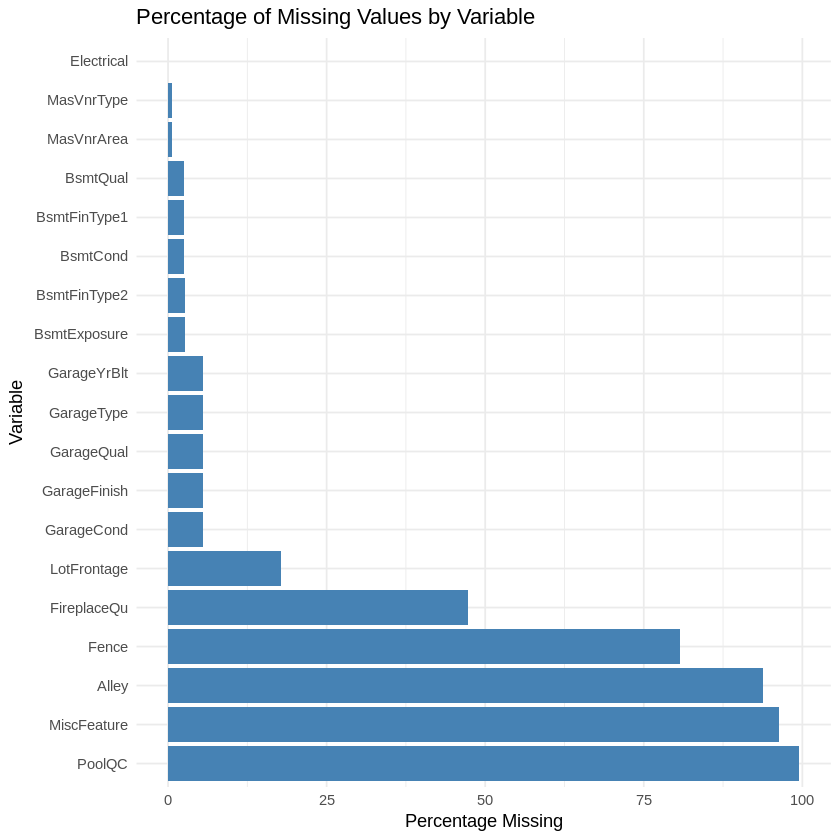

In [ ]:
# Calculate the count and percentage of missing values
missing_counts <- sapply(train_data_no_target, function(x) sum(is.na(x)))
missing_percentage <- missing_counts / nrow(train_data_no_target) * 100

# Create a data frame for missing values
missing_df <- data.frame(
    Variable = names(missing_percentage),
    MissingCount = missing_counts,
    MissingPercentage = missing_percentage
)

# Filter variables with missing values
missing_df <- missing_df %>% filter(MissingPercentage > 0)

# Sort by missing percentage for better visualization
missing_df <- missing_df %>% arrange(desc(MissingPercentage))

# Plot the missing values
library(ggplot2)
ggplot(missing_df, aes(x = reorder(Variable, -MissingPercentage), y = MissingPercentage)) +
    geom_bar(stat = "identity", fill = "steelblue") +
    coord_flip() +
    labs(
        title = "Percentage of Missing Values by Variable",
        x = "Variable",
        y = "Percentage Missing"
    ) +
    theme_minimal()

In [ ]:
# Step 3: Drop Columns with >50% Missing Values
threshold <- 0.5 * nrow(train_data_no_target)
missing_percents <- sapply(train_data_no_target, function(x) sum(is.na(x)) / nrow(train_data_no_target) * 100)
columns_to_drop <- names(missing_percents[missing_percents > 50])
train_data_cleaned <- train_data_no_target %>% select(-one_of(columns_to_drop))

cat("Number of columns removed due to >50% missing values:", length(columns_to_drop), "\n")
print(columns_to_drop)

Number of columns removed due to >50% missing values: 4 
[1] "Alley"       "PoolQC"      "Fence"       "MiscFeature"


In [ ]:
# Step 4: Impute Missing Values
train_data_imputed <- kNN(train_data_cleaned, k = 5)
train_data_imputed <- train_data_imputed[, !grepl("_imp", names(train_data_imputed))]

missing_values_after <- sum(is.na(train_data_imputed))
cat("Number of missing values after imputation:", missing_values_after, "\n")


Number of missing values after imputation: 0 


In [ ]:
# checking whether these predictors are relevant to our target variable
cor(train_data_imputed$YrSold, target)
cor(train_data_imputed$YearBuilt, target)
cor(train_data_imputed$YearRemodAdd, target)
cor(train_data_imputed$GarageYrBlt, target)


[1] -0.02892259

[1] 0.5228973

[1] 0.507101

[1] 0.4879952

In [ ]:
# ** Temporal Transformations Here**
# since YrSold had a negative correlation we will remove it
# we will change the rest of the yearly columns to age to make it numerical
# Calculate age-related features
train_data_imputed$HouseAge <- train_data_imputed$YrSold - train_data_imputed$YearBuilt
train_data_imputed$RemodelAge <- train_data_imputed$YrSold - train_data_imputed$YearRemodAdd
train_data_imputed$GarageAge <- train_data_imputed$YrSold - train_data_imputed$GarageYrBlt

# Drop the original year columns as they are no longer needed
train_data_imputed <- train_data_imputed %>% select(-YrSold, -YearBuilt, -YearRemodAdd, -GarageYrBlt)


In [ ]:
head(train_data_imputed)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,⋯,X3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SaleType,SaleCondition,HouseAge,RemodelAge,GarageAge
,<int>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<int>,<int>,<int>
1,60,RL,65,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,⋯,0,0,0,0,2,WD,Normal,5,5,5
2,20,RL,80,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,⋯,0,0,0,0,5,WD,Normal,31,31,31
3,60,RL,68,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,⋯,0,0,0,0,9,WD,Normal,7,6,7
4,70,RL,60,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,⋯,0,0,0,0,2,WD,Abnorml,91,36,8
5,60,RL,84,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,⋯,0,0,0,0,12,WD,Normal,8,8,8
6,50,RL,85,14115,Pave,IR1,Lvl,AllPub,Inside,Gtl,⋯,320,0,0,700,10,WD,Normal,16,14,16


In [ ]:
# the following columns are numeric but should actually be treated as categorical
# Step 5: Convert Select Numeric Columns to Factors
numeric_as_categorical <- c(
    "MSSubClass", # Dwelling type
    "OverallQual", # Overall quality
    "OverallCond", # Overall condition
    "MoSold" # Month sold (1-12)
)

# Convert only the identified numeric columns to factors
for (col in numeric_as_categorical) {
    if (col %in% names(train_data_imputed)) {
        train_data_imputed[[col]] <- as.factor(train_data_imputed[[col]])
    }
}

# Print predictors that were treated as categorical
cat("Predictors treated as categorical although they are numeric:\n")
print(numeric_as_categorical)


Predictors treated as categorical although they are numeric:
[1] "MSSubClass"  "OverallQual" "OverallCond" "MoSold"     


In [ ]:
# Step 6: Apply Dummification for all even for the above four columns
library(caret)

# Create dummy variables for categorical predictors
dummies <- dummyVars(~ ., data = train_data_imputed, fullRank = TRUE) # Avoid multicollinearity
train_data_dummified <- predict(dummies, newdata = train_data_imputed)

# Convert the resulting matrix to a data frame
train_data_dummified <- as.data.frame(train_data_dummified)

# Step 7: Print Details of Dummification
cat("Number of predictors after dummification:", ncol(train_data_dummified), "\n")
cat("Structure of dummified predictors:\n")
str(train_data_dummified)

Number of predictors after dummification: 273 
Structure of dummified predictors:
'data.frame':	1460 obs. of  273 variables:
 $ MSSubClass.30       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ MSSubClass.40       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ MSSubClass.45       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ MSSubClass.50       : num  0 0 0 0 0 1 0 0 1 0 ...
 $ MSSubClass.60       : num  1 0 1 0 1 0 0 1 0 0 ...
 $ MSSubClass.70       : num  0 0 0 1 0 0 0 0 0 0 ...
 $ MSSubClass.75       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ MSSubClass.80       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ MSSubClass.85       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ MSSubClass.90       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ MSSubClass.120      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ MSSubClass.160      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ MSSubClass.180      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ MSSubClass.190      : num  0 0 0 0 0 0 0 0 0 1 ...
 $ MSZoningFV          : num  0 0 0 0 0 0 0 0 0 0 ...
 $ MSZoningRH          : num  0 0 0 0 0 0 0 0 0 0 ...
 $ MSZoning

In [ ]:
# Identify dummy variables created for these predictors
dummy_vars_created <- grep(
    paste(numeric_as_categorical, collapse = "|"),
    names(train_data_dummified),
    value = TRUE
)

# Print the dummified columns
cat("Dummified variables created:\n")
print(dummy_vars_created)

Dummified variables created:
 [1] "MSSubClass.30"  "MSSubClass.40"  "MSSubClass.45"  "MSSubClass.50" 
 [5] "MSSubClass.60"  "MSSubClass.70"  "MSSubClass.75"  "MSSubClass.80" 
 [9] "MSSubClass.85"  "MSSubClass.90"  "MSSubClass.120" "MSSubClass.160"
[13] "MSSubClass.180" "MSSubClass.190" "OverallQual.2"  "OverallQual.3" 
[17] "OverallQual.4"  "OverallQual.5"  "OverallQual.6"  "OverallQual.7" 
[21] "OverallQual.8"  "OverallQual.9"  "OverallQual.10" "OverallCond.2" 
[25] "OverallCond.3"  "OverallCond.4"  "OverallCond.5"  "OverallCond.6" 
[29] "OverallCond.7"  "OverallCond.8"  "OverallCond.9"  "MoSold.2"      
[33] "MoSold.3"       "MoSold.4"       "MoSold.5"       "MoSold.6"      
[37] "MoSold.7"       "MoSold.8"       "MoSold.9"       "MoSold.10"     
[41] "MoSold.11"      "MoSold.12"     


In [ ]:
# Step 8: Remove Near-Zero Variance Predictors
nzv <- nearZeroVar(train_data_dummified, saveMetrics = TRUE)
train_data_no_nzv <- train_data_dummified[, !nzv$nzv]

cat("Number of predictors after removing NZV predictors:", ncol(train_data_no_nzv), "\n")


Number of predictors after removing NZV predictors: 114 


In [ ]:
# Step 9: Apply Box-Cox Transformation for Positive Numeric Predictors

# Identify positive numeric predictors (Box-Cox requires strictly positive values)
# numeric_predictors <- sapply(train_data_no_nzv, is.numeric)
# positive_numeric <- names(train_data_no_nzv)[numeric_predictors & apply(train_data_no_nzv, 2, function(x) all(x > 0))]

# cat("Positive numeric predictors for Box-Cox transformation:\n")
# print(positive_numeric)

# # Plot histograms before transformation
# par(mfrow = c(ceiling(length(positive_numeric) / 3), 3))  # Arrange histograms in rows of 3
# for (var in positive_numeric) {
   # hist(train_data_no_nzv[[var]], main = paste("Before Box-Cox -", var), xlab = var, col = "steelblue", breaks = 20)
# }
# par(mfrow = c(1, 1))  # Reset plotting layout

# Apply Box-Cox transformation using caret::preProcess
# library(caret)
# boxcox_transformation <- preProcess(train_data_no_nzv[, positive_numeric], method = "BoxCox")
# train_data_no_nzv[, positive_numeric] <- predict(boxcox_transformation, train_data_no_nzv[, positive_numeric])

# Plot histograms after transformation
# par(mfrow = c(ceiling(length(positive_numeric) / 3), 3))  # Arrange histograms in rows of 3
# for (var in positive_numeric) {
#     hist(train_data_no_nzv[[var]], main = paste("After Box-Cox -", var), xlab = var, col = "lightgreen", breaks = 20)
# }
# par(mfrow = c(1, 1))  # Reset plotting layout


In [ ]:


# Load required library
# library(caret)

# Apply spatial sign transformation to the data
# spatial_sign_transform <- preProcess(train_data_no_nzv, method = "spatialSign")
# train_data_spatial_sign <- predict(spatial_sign_transform, train_data_no_nzv)

# # Step 13: Visualize Results with Boxplots

# Define a function to create boxplots for original vs transformed data
# plot_boxplots <- function(original_data, transformed_data, vars) {
  #   par(mfrow = c(ceiling(length(vars) / 5), 3))  # Arrange plots in rows of 3
    # for (var in vars) {
      #   boxplot(
        #     original_data[[var]],
          #   transformed_data[[var]],
            # names = c("Original", "Transformed"),
           #  main = paste("Boxplot for", var),
            # col = c("steelblue", "lightgreen")
       #  )
   #  }
   #  par(mfrow = c(1, 1))  # Reset plotting layout
# }

# Identify numeric predictors for visualization
# numeric_vars <- names(train_data_no_nzv)[sapply(train_data_no_nzv, is.numeric)]

# Call the function to plot boxplots for the first 15 numeric variables (or adjust as needed)
# plot_boxplots(train_data_no_nzv, train_data_spatial_sign, vars = numeric_vars[1:15])

In [ ]:
# Define a function to create boxplots for original vs spatial sign-transformed data
 #Step 12: Apply Spatial Sign Transformation
#plot_boxplots <- function(original_data, transformed_data, vars) {
 #   par(mfrow = c(1, 2))  # Plot only 2 variables per page
  #  par(mar = c(5, 4, 4, 2) + 0.1)  # Reset margins
   # for (var in vars) {
    #    if (var %in% colnames(transformed_data)) {
     #       boxplot(
      #          original_data[[var]],
       #         transformed_data[[var]],
        #        names = c("Original", "Spatial Sign"),
         #       main = paste("Boxplot for", var),
          #      col = c("steelblue", "lightgreen")
          #  )
        #}
   # }
   # par(mfrow = c(1, 1))  # Reset layout after plotting
#}

# Example usage for the first 4 numeric variables
#plot_boxplots(train_data_imputed, train_data_spatial_sign, vars = numeric_vars[1:4])

In [ ]:
# Step 14: Split Data into Train and Test Sets (Random Split)
set.seed(123)  # For reproducibility

# Generate random indices for the training set
train_index <- sample(1:nrow(train_data_no_nzv), size = 0.8 * nrow(train_data_no_nzv), replace = FALSE)

# Create training and testing sets based on the random indices
train_set <- train_data_no_nzv[train_index, ]
test_set <- train_data_no_nzv[-train_index, ]

# Create corresponding target variables for training and testing sets
target_train <- target[train_index]
target_test <- target[-train_index]

# Print the sizes of the training and testing sets
cat("Training set size:", nrow(train_set), "\n")
cat("Testing set size:", nrow(test_set), "\n")


Training set size: 1168 
Testing set size: 292 


Highly correlated predictors (cutoff = 0.9):
[1] "RoofStyleHip"       "ExterQualTA"        "Exterior1stMetalSd"
[4] "Exterior1stVinylSd" "SaleTypeNew"       
Number of predictors after removing highly correlated ones in training set: 109 
Number of predictors after removing highly correlated ones in test set: 109 


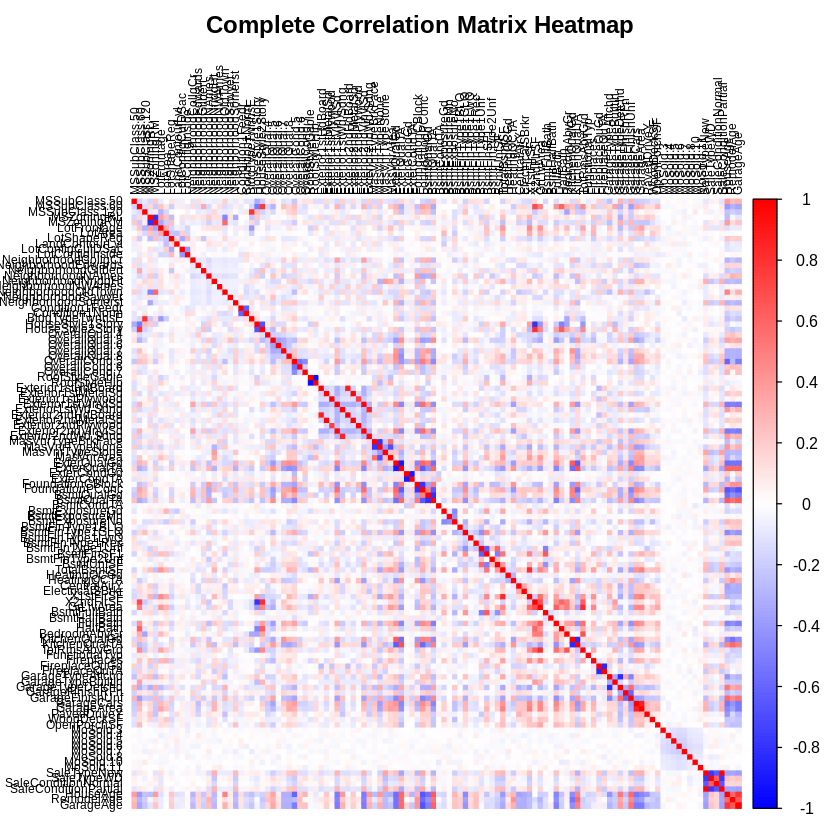

In [ ]:
# Step 11: Compute the Correlation Matrix and Remove Highly Correlated Predictors

# Compute the correlation matrix
cor_matrix <- cor(train_set)

# Plot the heatmap using corrplot
library(corrplot)
corrplot(
    cor_matrix,
    method = "color",          # Use colors for correlation values
    type = "full",             # Show the full square matrix
    tl.col = "black",          # Text color for labels
    tl.cex = 0.6,              # Adjust text size for labels
    col = colorRampPalette(c("blue", "white", "red"))(200), # Color gradient
    title = "Complete Correlation Matrix Heatmap",
    mar = c(0, 0, 2, 0)        # Margins for the plot
)

# Identify Highly Correlated Predictors
highly_correlated_train <- findCorrelation(cor_matrix, cutoff = 0.9, names = TRUE)

# Print highly correlated predictors
cat("Highly correlated predictors (cutoff = 0.9):\n")
print(highly_correlated_train)

# Create a version of the training set without highly correlated predictors
train_set_no_high_corr <- train_set %>% select(-one_of(highly_correlated_train))

# Apply the same transformation to the test set
test_set_no_high_corr <- test_set %>% select(-one_of(highly_correlated_train))

# Confirm dimensions after removing highly correlated predictors
cat("Number of predictors after removing highly correlated ones in training set:", ncol(train_set_no_high_corr), "\n")
cat("Number of predictors after removing highly correlated ones in test set:", ncol(test_set_no_high_corr), "\n")


### Here I was confused on where X1stFlrSF came from in the above histograms although it didn't exist in the original dataset. I realized that the original variables were 1stFlrSF and R automatically renamed them to X1stFlrSF since R doesn't allow variable names to start with a number.

In [ ]:
colnames(train_data)  #original dataset

[1] "Id"            "MSSubClass"    "MSZoning"      "LotFrontage"  
 [5] "LotArea"       "Street"        "Alley"         "LotShape"     
 [9] "LandContour"   "Utilities"     "LotConfig"     "LandSlope"    
[13] "Neighborhood"  "Condition1"    "Condition2"    "BldgType"     
[17] "HouseStyle"    "OverallQual"   "OverallCond"   "YearBuilt"    
[21] "YearRemodAdd"  "RoofStyle"     "RoofMatl"      "Exterior1st"  
[25] "Exterior2nd"   "MasVnrType"    "MasVnrArea"    "ExterQual"    
[29] "ExterCond"     "Foundation"    "BsmtQual"      "BsmtCond"     
[33] "BsmtExposure"  "BsmtFinType1"  "BsmtFinSF1"    "BsmtFinType2" 
[37] "BsmtFinSF2"    "BsmtUnfSF"     "TotalBsmtSF"   "Heating"      
[41] "HeatingQC"     "CentralAir"    "Electrical"    "X1stFlrSF"    
[45] "X2ndFlrSF"     "LowQualFinSF"  "GrLivArea"     "BsmtFullBath" 
[49] "BsmtHalfBath"  "FullBath"      "HalfBath"      "BedroomAbvGr" 
[53] "KitchenAbvGr"  "KitchenQual"   "TotRmsAbvGrd"  "Functional"   
[57] "Fireplaces"    "FireplaceQu"   "GarageType"    "GarageYrBlt"  
[61] "GarageFinish"  "GarageCars"    "GarageArea"    "GarageQual"   
[65] "GarageCond"    "PavedDrive"    "WoodDeckSF"    "OpenPorchSF"  
[69] "EnclosedPorch" "X3SsnPorch"    "ScreenPorch"   "PoolArea"     
[73] "PoolQC"        "Fence"         "MiscFeature"   "MiscVal"      
[77] "MoSold"        "YrSold"        "SaleType"      "SaleCondition"
[81] "SalePrice"

In [ ]:
# checked the transformed one to see if the name was changed during preprocessing
colnames(train_set_no_high_corr)

[1] "MSSubClass.50"        "MSSubClass.60"        "MSSubClass.120"      
  [4] "MSZoningRL"           "MSZoningRM"           "LotFrontage"         
  [7] "LotArea"              "LotShapeReg"          "LandContourLvl"      
 [10] "LotConfigCulDSac"     "LotConfigInside"      "NeighborhoodCollgCr" 
 [13] "NeighborhoodEdwards"  "NeighborhoodGilbert"  "NeighborhoodNAmes"   
 [16] "NeighborhoodNridgHt"  "NeighborhoodNWAmes"   "NeighborhoodOldTown" 
 [19] "NeighborhoodSawyer"   "NeighborhoodSomerst"  "Condition1Feedr"     
 [22] "Condition1Norm"       "BldgTypeTwnhsE"       "HouseStyle1Story"    
 [25] "HouseStyle2Story"     "OverallQual.4"        "OverallQual.5"       
 [28] "OverallQual.6"        "OverallQual.7"        "OverallQual.8"       
 [31] "OverallCond.5"        "OverallCond.6"        "OverallCond.7"       
 [34] "RoofStyleGable"       "Exterior1stHdBoard"   "Exterior1stPlywood"  
 [37] "Exterior1stWd Sdng"   "Exterior2ndHdBoard"   "Exterior2ndMetalSd"  
 [40] "Exterior2ndPlywood"   "Exterior2ndVinylSd"   "Exterior2ndWd Sdng"  
 [43] "MasVnrTypeBrkFace"    "MasVnrTypeNone"       "MasVnrTypeStone"     
 [46] "MasVnrArea"           "ExterQualGd"          "ExterCondGd"         
 [49] "ExterCondTA"          "FoundationCBlock"     "FoundationPConc"     
 [52] "BsmtQualGd"           "BsmtQualTA"           "BsmtCondTA"          
 [55] "BsmtExposureGd"       "BsmtExposureMn"       "BsmtExposureNo"      
 [58] "BsmtFinType1BLQ"      "BsmtFinType1GLQ"      "BsmtFinType1LwQ"     
 [61] "BsmtFinType1Rec"      "BsmtFinType1Unf"      "BsmtFinSF1"          
 [64] "BsmtFinType2Unf"      "BsmtUnfSF"            "TotalBsmtSF"         
 [67] "HeatingQCGd"          "HeatingQCTA"          "CentralAirY"         
 [70] "ElectricalSBrkr"      "X1stFlrSF"            "X2ndFlrSF"           
 [73] "GrLivArea"            "BsmtFullBath"         "BsmtHalfBath"        
 [76] "FullBath"             "HalfBath"             "BedroomAbvGr"        
 [79] "KitchenQualGd"        "KitchenQualTA"        "TotRmsAbvGrd"        
 [82] "FunctionalTyp"        "Fireplaces"           "FireplaceQuGd"       
 [85] "FireplaceQuTA"        "GarageTypeAttchd"     "GarageTypeBuiltIn"   
 [88] "GarageTypeDetchd"     "GarageFinishRFn"      "GarageFinishUnf"     
 [91] "GarageCars"           "GarageArea"           "PavedDriveY"         
 [94] "WoodDeckSF"           "OpenPorchSF"          "MoSold.3"            
 [97] "MoSold.4"             "MoSold.5"             "MoSold.6"            
[100] "MoSold.7"             "MoSold.8"             "MoSold.10"           
[103] "MoSold.11"            "SaleTypeWD"           "SaleConditionNormal" 
[106] "SaleConditionPartial" "HouseAge"             "RemodelAge"          
[109] "GarageAge"

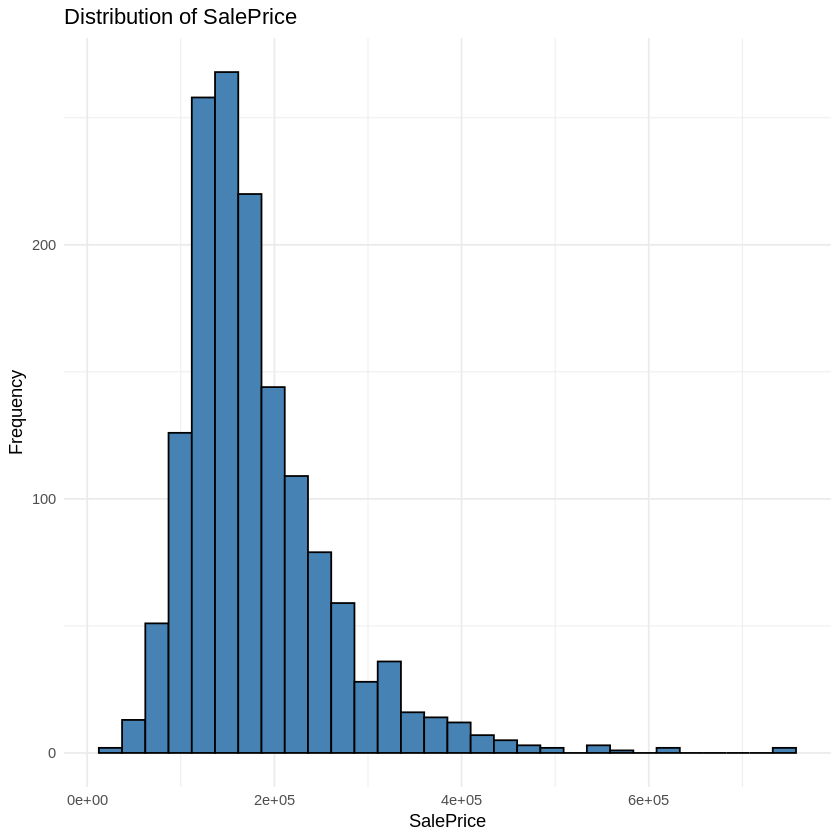

In [ ]:


ggplot(train_data, aes(x = SalePrice)) +
    geom_histogram(bins = 30, fill = "steelblue", color = "black") +
    labs(title = "Distribution of SalePrice", x = "SalePrice", y = "Frequency") +
    theme_minimal()

In [ ]:
install.packages("moments")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(moments)

skewness_value <- skewness(train_data$SalePrice)
cat("Skewness of SalePrice:", skewness_value, "\n")

Skewness of SalePrice: 1.880941 


In [ ]:
# Save both versions of the data for flexibility
train_set_with_corr <- train_set
test_set_with_corr <- test_set
train_set_no_corr <- train_set_no_high_corr
test_set_no_corr <- test_set_no_high_corr

In [ ]:
dim(train_set_with_corr)
dim(test_set_with_corr)

[1] 1168  114

[1] 292 114

In [ ]:
dim(train_set_no_corr)
dim(test_set_no_corr)

[1] 1168  109

[1] 292 109

In [ ]:
install.packages("MASS")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
str(train_models_no_corr$SalePrice)

'data.frame':	1168 obs. of  1 variable:
 $ SalePrice: num  12.3 11 13.1 12.1 11.8 ...


In [ ]:
#train_models_no_corr$SalePrice <- as.numeric(unlist(train_models_no_corr$SalePrice))
#train_models_with_corr$SalePrice <- as.numeric(unlist(train_models_with_corr$SalePrice))


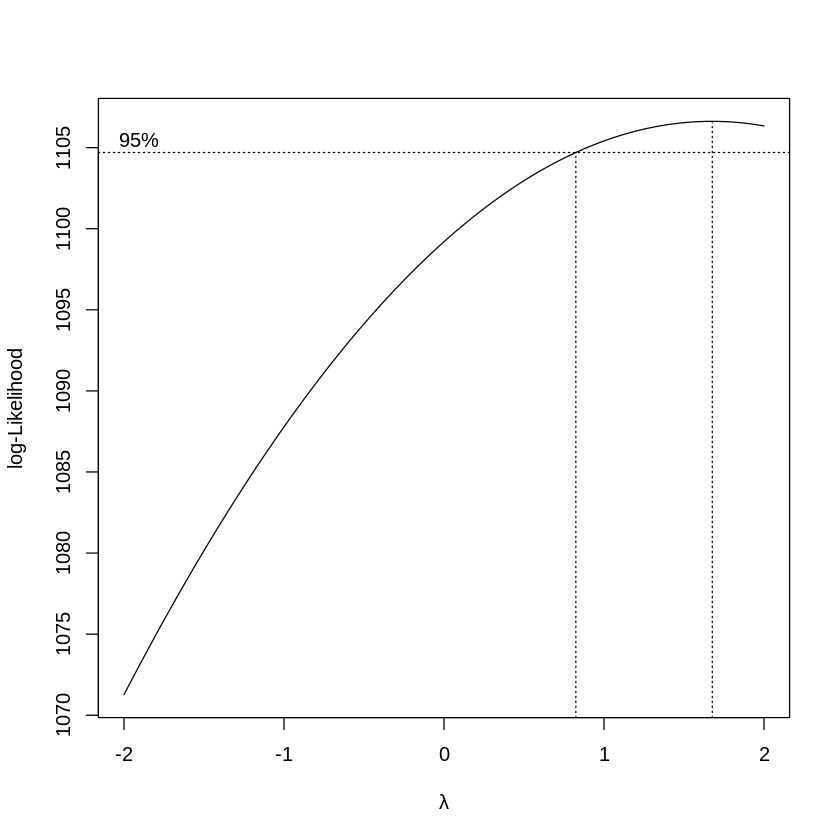

In [ ]:
boxcox_lm_no_corr <- lm(SalePrice ~ ., data = train_models_no_corr)
boxcox_result_no_corr <- boxcox(boxcox_lm_no_corr, lambda = seq(-2, 2, by = 0.1))

In [ ]:
# Step 1: Prepare the Data
# Combine the target variable with the training set
train_models_no_corr <- cbind(train_set_no_corr, SalePrice = target_train)
#train_models_no_corr$SalePrice <- log1p(train_models_no_corr$SalePrice)
boxcox_transformation_no_corr <- preProcess(train_models_no_corr[, "SalePrice", drop = FALSE], method = "BoxCox")
train_models_no_corr$SalePrice <- predict(boxcox_transformation_no_corr, train_models_no_corr[, "SalePrice", drop = FALSE])


In [ ]:
train_models_with_corr <- cbind(train_set_with_corr, SalePrice = target_train)
#train_models_with_corr$SalePrice <- log1p(train_models_with_corr$SalePrice)
boxcox_transformation_with_corr <- preProcess(train_models_with_corr[, "SalePrice", drop = FALSE], method = "BoxCox")
train_models_with_corr$SalePrice <- predict(boxcox_transformation_with_corr, train_models_with_corr[, "SalePrice", drop = FALSE])


In [ ]:

#skewness_value_transformed <- skewness(train_models_with_corr$SalePrice)
#cat("Skewness of SalePrice after log transformation:", skewness_value_transformed, "\n")

In [ ]:
# Step 2: Define 10-Fold Cross-Validation
folds <- trainControl(
  method = "cv",           # Cross-validation
  number = 10,             # Number of folds
  verboseIter = TRUE       # Print progress
)

In [ ]:
dim(train_models_no_corr)

[1] 1168  110

In [ ]:
train_models_no_corr$SalePrice <- as.numeric(unlist(train_models_no_corr$SalePrice))
train_models_with_corr$SalePrice <- as.numeric(unlist(train_models_with_corr$SalePrice))

In [ ]:
skewness_test_no_corr <- skewness(test_models_no_corr$SalePrice)
skewness_test_with_corr <- skewness(test_models_with_corr$SalePrice)

cat("Skewness of SalePrice (Test, No Correlation):", skewness_test_no_corr, "\n")
cat("Skewness of SalePrice (Test, With Correlation):", skewness_test_with_corr, "\n")

Skewness of SalePrice (Test, No Correlation): -0.2194809 
Skewness of SalePrice (Test, With Correlation): -0.2194809 


In [ ]:
str(train_models_no_corr$SalePrice)

 num [1:1168] 12.3 11 13.1 12.1 11.8 ...


In [ ]:


# Step 3: Build the OLS Model
set.seed(123)
ols_model <- train(
  SalePrice ~ .,           # Specify target and predictors
  data = train_models_no_corr,        # Training set
  method = "lm",           # Ordinary Least Squares (OLS)
  trControl = folds,       # 10-fold CV
  preProcess = c("center", "scale")
)

# Step 4: Summarize Model Performance on Training Set
ols_model

# Step 5: Generate Tuning Plot (if applicable)
# OLS does not have tuning parameters, so no plot is generated for this step.

# Save the model summary for later comparison
ols_model_summary <- ols_model$results

+ Fold01: intercept=TRUE 
- Fold01: intercept=TRUE 
+ Fold02: intercept=TRUE 
- Fold02: intercept=TRUE 
+ Fold03: intercept=TRUE 
- Fold03: intercept=TRUE 
+ Fold04: intercept=TRUE 
- Fold04: intercept=TRUE 
+ Fold05: intercept=TRUE 
- Fold05: intercept=TRUE 
+ Fold06: intercept=TRUE 
- Fold06: intercept=TRUE 
+ Fold07: intercept=TRUE 
- Fold07: intercept=TRUE 
+ Fold08: intercept=TRUE 
- Fold08: intercept=TRUE 
+ Fold09: intercept=TRUE 
- Fold09: intercept=TRUE 
+ Fold10: intercept=TRUE 
- Fold10: intercept=TRUE 
Aggregating results
Fitting final model on full training set


Linear Regression 

1168 samples
 109 predictor

Pre-processing: centered (109), scaled (109) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 1050, 1051, 1052, 1051, 1052, 1051, ... 
Resampling results:

  RMSE       Rsquared   MAE      
  0.1634916  0.8348211  0.1082441

Tuning parameter 'intercept' was held constant at a value of TRUE

In [ ]:
install.packages("elasticnet")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
dim(train_models_with_corr)

[1] 1168  115

+ Fold01: lambda=0.000000 
- Fold01: lambda=0.000000 
+ Fold01: lambda=0.007143 
- Fold01: lambda=0.007143 
+ Fold01: lambda=0.014286 
- Fold01: lambda=0.014286 
+ Fold01: lambda=0.021429 
- Fold01: lambda=0.021429 
+ Fold01: lambda=0.028571 
- Fold01: lambda=0.028571 
+ Fold01: lambda=0.035714 
- Fold01: lambda=0.035714 
+ Fold01: lambda=0.042857 
- Fold01: lambda=0.042857 
+ Fold01: lambda=0.050000 
- Fold01: lambda=0.050000 
+ Fold01: lambda=0.057143 
- Fold01: lambda=0.057143 
+ Fold01: lambda=0.064286 
- Fold01: lambda=0.064286 
+ Fold01: lambda=0.071429 
- Fold01: lambda=0.071429 
+ Fold01: lambda=0.078571 
- Fold01: lambda=0.078571 
+ Fold01: lambda=0.085714 
- Fold01: lambda=0.085714 
+ Fold01: lambda=0.092857 
- Fold01: lambda=0.092857 
+ Fold01: lambda=0.100000 
- Fold01: lambda=0.100000 
+ Fold02: lambda=0.000000 
- Fold02: lambda=0.000000 
+ Fold02: lambda=0.007143 
- Fold02: lambda=0.007143 
+ Fold02: lambda=0.014286 
- Fold02: lambda=0.014286 
+ Fold02: lambda=0.021429 
-

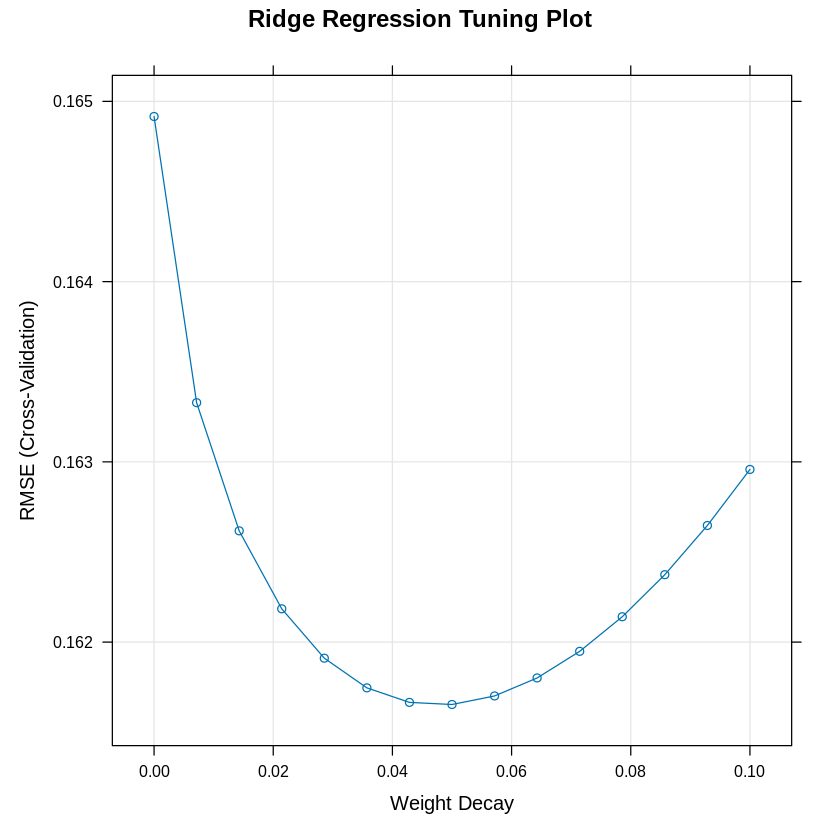

In [ ]:
# Step 3: Build Ridge Regression Model
set.seed(123)

# Define the tuning grid for ridge regression (lambda parameter)
ridge_grid <- expand.grid(.lambda = seq(0, 0.1, length = 15))

# Train the ridge regression model
ridge_model <- train(
  SalePrice ~ .,           # Formula specifying target and predictors
  data = train_models_with_corr,   # Training set with combined target variable
  method = "ridge",        # Ridge regression method
  tuneGrid = ridge_grid,   # Specify lambda values for tuning
  trControl = folds,       # 10-fold CV
  preProcess = c("center", "scale") # Standardize predictors
)

# Step 4: Summarize Ridge Model Performance on Training Set
print(ridge_model)


# Summarize model performance
cat("RMSE:", min(ridge_model$results$RMSE), "\n")
cat("R-squared:", ridge_model$results$Rsquared[which.min(ridge_model$results$RMSE)], "\n")

# Step 5: Generate Tuning Plot
plot(ridge_model, main = "Ridge Regression Tuning Plot")

# Save the model summary for later comparison
ridge_model_summary <- ridge_model$results

In [ ]:
install.packages("glmnet")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Loading required package: Matrix

Loaded glmnet 4.1-8



+ Fold01: alpha=1, lambda=0.1 
- Fold01: alpha=1, lambda=0.1 
+ Fold02: alpha=1, lambda=0.1 
- Fold02: alpha=1, lambda=0.1 
+ Fold03: alpha=1, lambda=0.1 
- Fold03: alpha=1, lambda=0.1 
+ Fold04: alpha=1, lambda=0.1 
- Fold04: alpha=1, lambda=0.1 
+ Fold05: alpha=1, lambda=0.1 
- Fold05: alpha=1, lambda=0.1 
+ Fold06: alpha=1, lambda=0.1 
- Fold06: alpha=1, lambda=0.1 
+ Fold07: alpha=1, lambda=0.1 
- Fold07: alpha=1, lambda=0.1 
+ Fold08: alpha=1, lambda=0.1 
- Fold08: alpha=1, lambda=0.1 
+ Fold09: alpha=1, lambda=0.1 
- Fold09: alpha=1, lambda=0.1 
+ Fold10: alpha=1, lambda=0.1 
- Fold10: alpha=1, lambda=0.1 
Aggregating results
Selecting tuning parameters
Fitting alpha = 1, lambda = 0.001 on full training set


glmnet 

1168 samples
 114 predictor

Pre-processing: centered (114), scaled (114) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 1050, 1051, 1052, 1051, 1052, 1051, ... 
Resampling results across tuning parameters:

  lambda    RMSE       Rsquared   MAE      
  0.001000  0.1607747  0.8402121  0.1066377
  0.005125  0.1614176  0.8406331  0.1061774
  0.009250  0.1646203  0.8362193  0.1080076
  0.013375  0.1681816  0.8314115  0.1104466
  0.017500  0.1718196  0.8269118  0.1131671
  0.021625  0.1753167  0.8229454  0.1158261
  0.025750  0.1790382  0.8185344  0.1185902
  0.029875  0.1826592  0.8143255  0.1213101
  0.034000  0.1862289  0.8102505  0.1240119
  0.038125  0.1895537  0.8067078  0.1266355
  0.042250  0.1928342  0.8034421  0.1294014
  0.046375  0.1960879  0.8003322  0.1322137
  0.050500  0.1991311  0.7979896  0.1347595
  0.054625  0.2020291  0.7961286  0.1371820
  0.058750  0.2048753  0.7945089  0.1395704
  0.062875  0.2077390  0.7930886  0.1419552
  0.067000  0.210

RMSE: 0.1607747 
R-squared: 0.8402121 


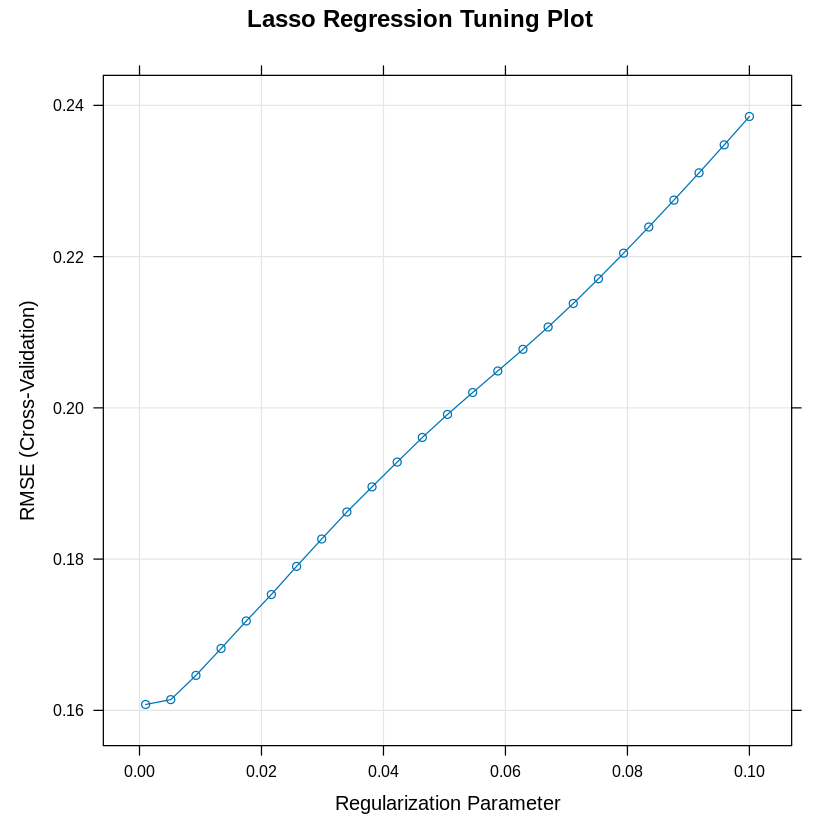

In [ ]:
library(glmnet)

# Step 3: Build Lasso Regression Model
set.seed(123)

# Define the tuning grid for Lasso (lambda values)
lasso_grid <- expand.grid(
  .alpha = 1,                 # Alpha = 1 for Lasso
  .lambda = seq(0.001, 0.1, length = 25) # Tuning lambda
)

# Train the Lasso regression model
lasso_model <- train(
  SalePrice ~ .,             # Formula specifying target and predictors
  data = train_models_with_corr,   # Training set with combined target variable
  method = "glmnet",         # Use glmnet for Lasso
  tuneGrid = lasso_grid,     # Specify alpha and lambda values for tuning
  trControl = folds,
  preProcess = c("center", "scale")        # 10-fold CV

)

# Step 4: Summarize Lasso Model Performance
lasso_model


# Summarize model performance
cat("RMSE:", min(lasso_model$results$RMSE), "\n")
cat("R-squared:", lasso_model$results$Rsquared[which.min(lasso_model$results$RMSE)], "\n")

# Step 5: Generate Tuning Plot
plot(lasso_model, main = "Lasso Regression Tuning Plot")

# Save the model summary for later comparison
lasso_model_summary <- lasso_model$results

+ Fold01: alpha=0.1, lambda=0.1 
- Fold01: alpha=0.1, lambda=0.1 
+ Fold01: alpha=0.2, lambda=0.1 
- Fold01: alpha=0.2, lambda=0.1 
+ Fold01: alpha=0.3, lambda=0.1 
- Fold01: alpha=0.3, lambda=0.1 
+ Fold01: alpha=0.4, lambda=0.1 
- Fold01: alpha=0.4, lambda=0.1 
+ Fold01: alpha=0.5, lambda=0.1 
- Fold01: alpha=0.5, lambda=0.1 
+ Fold01: alpha=0.6, lambda=0.1 
- Fold01: alpha=0.6, lambda=0.1 
+ Fold01: alpha=0.7, lambda=0.1 
- Fold01: alpha=0.7, lambda=0.1 
+ Fold01: alpha=0.8, lambda=0.1 
- Fold01: alpha=0.8, lambda=0.1 
+ Fold01: alpha=0.9, lambda=0.1 
- Fold01: alpha=0.9, lambda=0.1 
+ Fold01: alpha=1.0, lambda=0.1 
- Fold01: alpha=1.0, lambda=0.1 
+ Fold02: alpha=0.1, lambda=0.1 
- Fold02: alpha=0.1, lambda=0.1 
+ Fold02: alpha=0.2, lambda=0.1 
- Fold02: alpha=0.2, lambda=0.1 
+ Fold02: alpha=0.3, lambda=0.1 
- Fold02: alpha=0.3, lambda=0.1 
+ Fold02: alpha=0.4, lambda=0.1 
- Fold02: alpha=0.4, lambda=0.1 
+ Fold02: alpha=0.5, lambda=0.1 
- Fold02: alpha=0.5, lambda=0.1 
+ Fold02: 

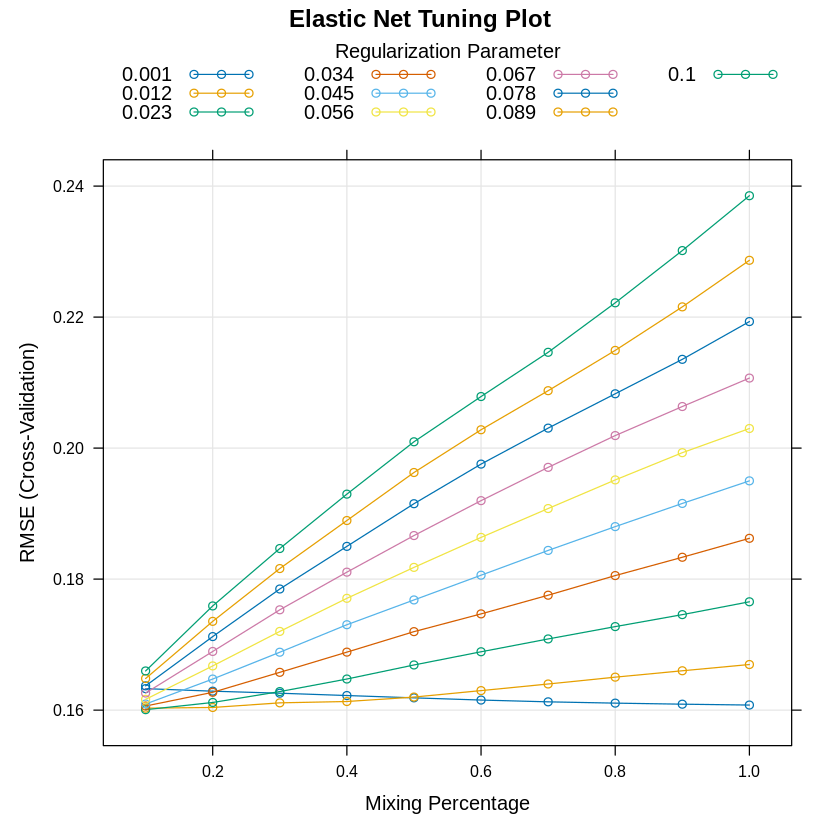

In [ ]:
# Step 3: Build Elastic Net Regression Model
set.seed(123)

# Define the tuning grid for Elastic Net
enet_grid <- expand.grid(
  .alpha = seq(0.1, 1, by = 0.1),  # Alpha controls the balance between Lasso (1) and Ridge (0)
  .lambda = seq(0.001, 0.1, length = 10) # Tuning lambda
)

# Train the Elastic Net model
enet_model <- train(
  SalePrice ~ .,             # Formula specifying target and predictors
  data = train_models_with_corr,   # Training set with combined target variable
  method = "glmnet",         # Use glmnet for Elastic Net
  tuneGrid = enet_grid,      # Specify alpha and lambda values for tuning
  trControl = folds,         # 10-fold CV
  preProcess = c("center", "scale") # Standardize predictors
)

# Step 4: Summarize Elastic Net Model Performance
print(enet_model)


# Summarize model performance
cat("RMSE:", min(enet_model$results$RMSE), "\n")
cat("R-squared:", enet_model$results$Rsquared[which.min(enet_model$results$RMSE)], "\n")

# Step 5: Generate Tuning Plot
plot(enet_model, main = "Elastic Net Tuning Plot")

# Save the model summary for later comparison
enet_model_summary <- enet_model$results

In [ ]:
install.packages("pls")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



+ Fold01: ncomp=10 
- Fold01: ncomp=10 
+ Fold02: ncomp=10 
- Fold02: ncomp=10 
+ Fold03: ncomp=10 
- Fold03: ncomp=10 
+ Fold04: ncomp=10 
- Fold04: ncomp=10 
+ Fold05: ncomp=10 
- Fold05: ncomp=10 
+ Fold06: ncomp=10 
- Fold06: ncomp=10 
+ Fold07: ncomp=10 
- Fold07: ncomp=10 
+ Fold08: ncomp=10 
- Fold08: ncomp=10 
+ Fold09: ncomp=10 
- Fold09: ncomp=10 
+ Fold10: ncomp=10 
- Fold10: ncomp=10 
Aggregating results
Selecting tuning parameters
Fitting ncomp = 9 on full training set
Principal Component Analysis 

1168 samples
 114 predictor

Pre-processing: centered (114), scaled (114) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 1050, 1051, 1052, 1051, 1052, 1051, ... 
Resampling results across tuning parameters:

  ncomp  RMSE       Rsquared   MAE      
   1     0.2340916  0.6500603  0.1750373
   2     0.2211095  0.6879579  0.1598382
   3     0.2081467  0.7251805  0.1518234
   4     0.1901624  0.7751062  0.1309746
   5     0.1804384  0.7986117  0.1223246
   6     0

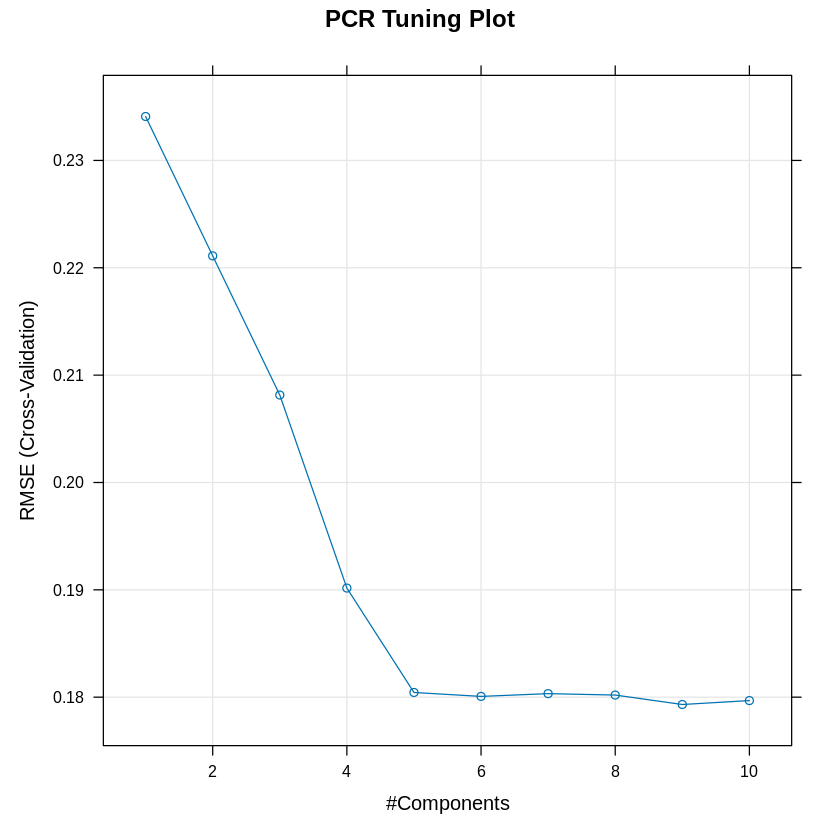

In [ ]:
# Step 1: Load Required Libraries
library(caret)

# Step 2: Train PCR Model
set.seed(123)
pcr_model <- train(
  SalePrice ~ .,              # Formula specifying target and predictors
  data = train_models_with_corr,  # Training set with combined target variable
  method = "pcr",             # Principal Component Regression
  tuneLength = 10,            # Number of principal components to evaluate
  trControl = folds,          # 10-fold cross-validation
  preProcess = c("center", "scale") # Standardize predictors
)

# Step 3: Summarize PCR Model Performance on Training Set
print(pcr_model)

# Step 4: Generate Tuning Plot
plot(pcr_model, main = "PCR Tuning Plot")



# Summarize model performance
cat("RMSE:", min(pcr_model$results$RMSE), "\n")
cat("R-squared:", pcr_model$results$Rsquared[which.min(pcr_model$results$RMSE)], "\n")

# Step 5: Save the Model Summary for Later Comparison
pcr_model_summary <- pcr_model$results

+ Fold01: ncomp=30 
- Fold01: ncomp=30 
+ Fold02: ncomp=30 
- Fold02: ncomp=30 
+ Fold03: ncomp=30 
- Fold03: ncomp=30 
+ Fold04: ncomp=30 
- Fold04: ncomp=30 
+ Fold05: ncomp=30 
- Fold05: ncomp=30 
+ Fold06: ncomp=30 
- Fold06: ncomp=30 
+ Fold07: ncomp=30 
- Fold07: ncomp=30 
+ Fold08: ncomp=30 
- Fold08: ncomp=30 
+ Fold09: ncomp=30 
- Fold09: ncomp=30 
+ Fold10: ncomp=30 
- Fold10: ncomp=30 
Aggregating results
Selecting tuning parameters
Fitting ncomp = 3 on full training set
Partial Least Squares 

1168 samples
 114 predictor

Pre-processing: centered (114), scaled (114) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 1050, 1051, 1052, 1051, 1052, 1051, ... 
Resampling results across tuning parameters:

  ncomp  RMSE       Rsquared   MAE      
   1     0.2033927  0.7383868  0.1481675
   2     0.1683947  0.8245489  0.1116601
   3     0.1613994  0.8384435  0.1087966
   4     0.1617161  0.8383151  0.1092727
   5     0.1621271  0.8379982  0.1097695
   6     0.162842

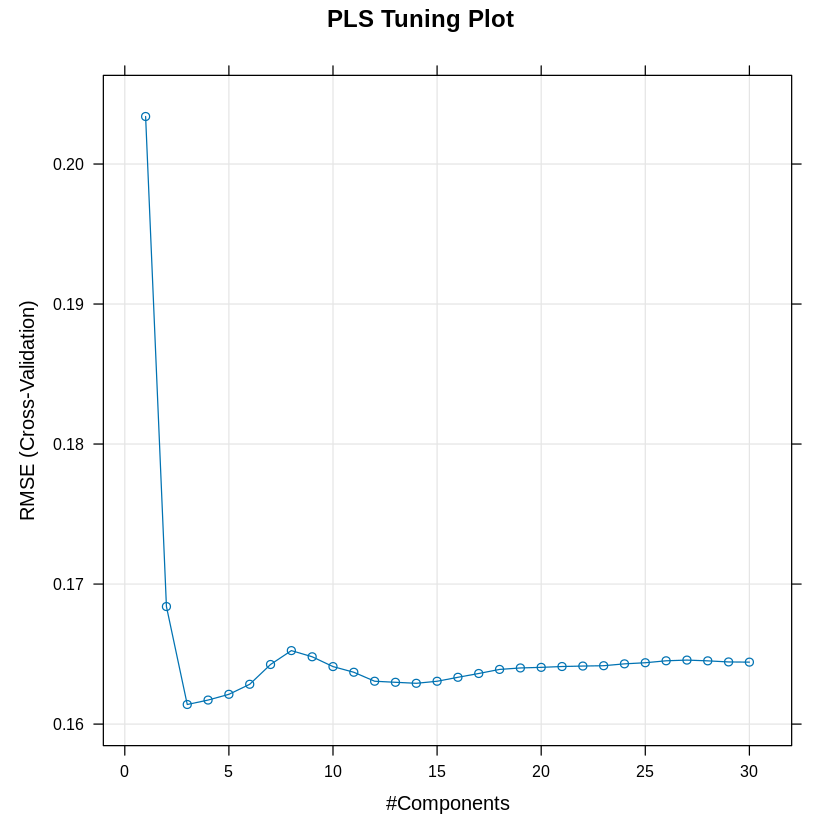

In [ ]:
# Step 1: Train the PLS Model
set.seed(123)
pls_model <- train(
  SalePrice ~ .,           # Formula specifying target and predictors
  data = train_models_with_corr,        # Training set
  method = "pls",          # Partial Least Squares
  tuneLength = 30,         # Number of components to evaluate
  trControl = folds,       # 10-fold cross-validation
  preProcess = c("center", "scale") # Standardize predictors
)

# Step 2: Summarize PLS Model Performance on Training Set
print(pls_model)

# Summarize model performance
cat("RMSE:", min(pls_model$results$RMSE), "\n")
cat("R-squared:", pls_model$results$Rsquared[which.min(pls_model$results$RMSE)], "\n")
# Step 3: Generate Tuning Plot
plot(pls_model, main = "PLS Tuning Plot")

# Step 4: Save the Model Summary for Later Comparison
pls_model_summary <- pls_model$results

# non linear models

In [ ]:
install.packages("earth")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘plotrix’, ‘plotmo’




Loading required package: Formula

Loading required package: plotmo

Loading required package: plotrix



+ Fold01: degree=1, nprune=38 
- Fold01: degree=1, nprune=38 
+ Fold01: degree=2, nprune=38 
- Fold01: degree=2, nprune=38 
+ Fold02: degree=1, nprune=38 
- Fold02: degree=1, nprune=38 
+ Fold02: degree=2, nprune=38 
- Fold02: degree=2, nprune=38 
+ Fold03: degree=1, nprune=38 
- Fold03: degree=1, nprune=38 
+ Fold03: degree=2, nprune=38 
- Fold03: degree=2, nprune=38 
+ Fold04: degree=1, nprune=38 
- Fold04: degree=1, nprune=38 
+ Fold04: degree=2, nprune=38 
- Fold04: degree=2, nprune=38 
+ Fold05: degree=1, nprune=38 
- Fold05: degree=1, nprune=38 
+ Fold05: degree=2, nprune=38 
- Fold05: degree=2, nprune=38 
+ Fold06: degree=1, nprune=38 
- Fold06: degree=1, nprune=38 
+ Fold06: degree=2, nprune=38 
- Fold06: degree=2, nprune=38 
+ Fold07: degree=1, nprune=38 
- Fold07: degree=1, nprune=38 
+ Fold07: degree=2, nprune=38 
- Fold07: degree=2, nprune=38 
+ Fold08: degree=1, nprune=38 
- Fold08: degree=1, nprune=38 
+ Fold08: degree=2, nprune=38 
- Fold08: degree=2, nprune=38 
+ Fold09

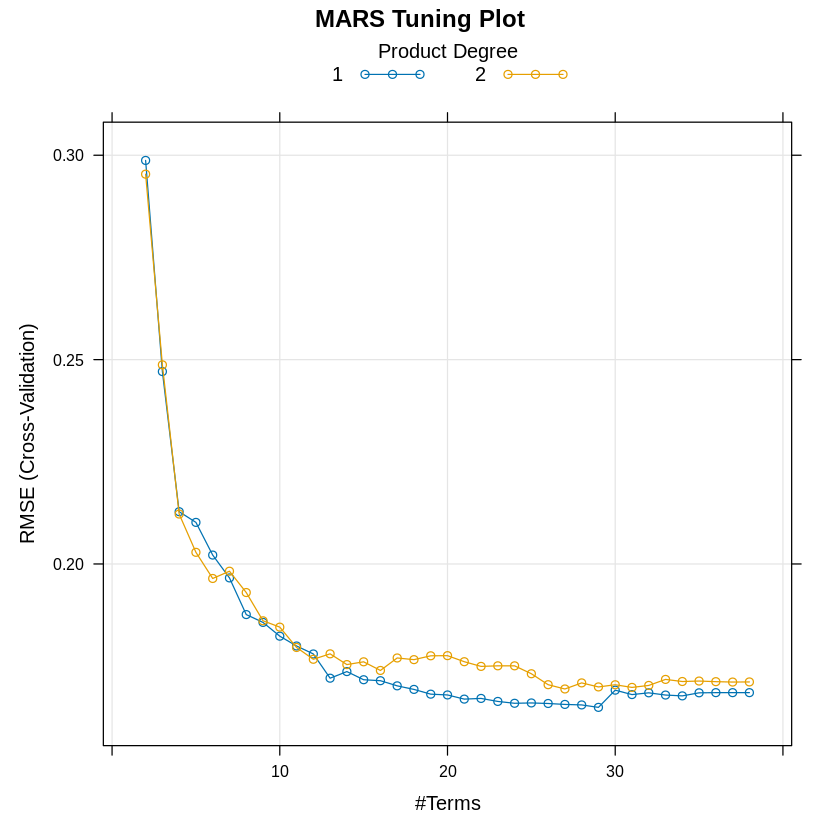

In [ ]:
library(earth)
# Step 1: Train the MARS Model
marsGrid <- expand.grid(.degree = 1:2, .nprune = 2:38)  ## Change 50 to 38

set.seed(123)
mars_model <- train(
  SalePrice ~ .,           # Formula specifying target and predictors
  data = train_models_with_corr,        # Training set
  method = "earth",        # MARS method in caret
  tuneGrid = marsGrid,
  trControl = folds # Standardize predictors
)

# Step 2: Summarize MARS Model Performance on Training Set
print(mars_model)

# Step 3: Generate Tuning Plot
plot(mars_model, main = "MARS Tuning Plot")

cat("Model Performance:\n")
cat("RMSE:", min(mars_model$results$RMSE), "\n")
cat("R-squared:", mars_model$results$Rsquared[which.min(mars_model$results$RMSE)], "\n")

# Step 4: Save the Model Summary for Later Comparison
mars_model_summary <- mars_model$results

In [ ]:
install.packages("kernlab")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



+ Fold01: sigma=0.00497, C=  0.25 
- Fold01: sigma=0.00497, C=  0.25 
+ Fold01: sigma=0.00497, C=  0.50 
- Fold01: sigma=0.00497, C=  0.50 
+ Fold01: sigma=0.00497, C=  1.00 
- Fold01: sigma=0.00497, C=  1.00 
+ Fold01: sigma=0.00497, C=  2.00 
- Fold01: sigma=0.00497, C=  2.00 
+ Fold01: sigma=0.00497, C=  4.00 
- Fold01: sigma=0.00497, C=  4.00 
+ Fold01: sigma=0.00497, C=  8.00 
- Fold01: sigma=0.00497, C=  8.00 
+ Fold01: sigma=0.00497, C= 16.00 
- Fold01: sigma=0.00497, C= 16.00 
+ Fold01: sigma=0.00497, C= 32.00 
- Fold01: sigma=0.00497, C= 32.00 
+ Fold01: sigma=0.00497, C= 64.00 
- Fold01: sigma=0.00497, C= 64.00 
+ Fold01: sigma=0.00497, C=128.00 
- Fold01: sigma=0.00497, C=128.00 
+ Fold02: sigma=0.00497, C=  0.25 
- Fold02: sigma=0.00497, C=  0.25 
+ Fold02: sigma=0.00497, C=  0.50 
- Fold02: sigma=0.00497, C=  0.50 
+ Fold02: sigma=0.00497, C=  1.00 
- Fold02: sigma=0.00497, C=  1.00 
+ Fold02: sigma=0.00497, C=  2.00 
- Fold02: sigma=0.00497, C=  2.00 
+ Fold02: sigma=0.00

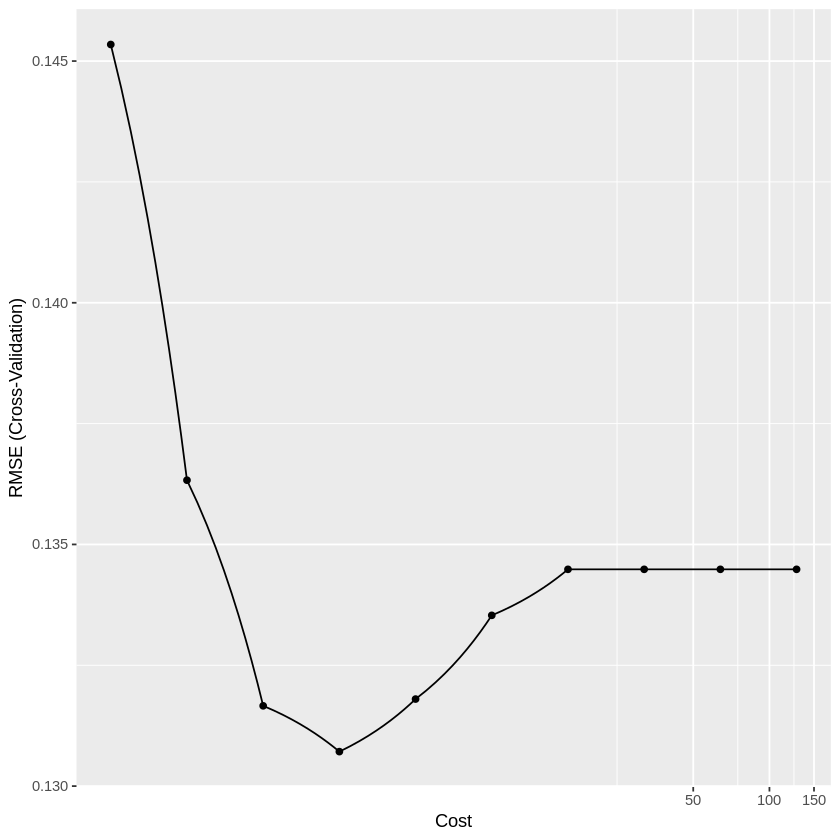

In [ ]:

# Define the grid for tuning
#grid <- expand.grid(
#  C = c(0.01, 0.1, 1, 10),        # Cost values
 # sigma = c(0.01, 0.1, 1, 10)    # Sigma values
#)

# Perform SVM tuning
set.seed(123)
svm_model <- train(
  SalePrice ~ .,                 # Formula
  data = train_models_with_corr,              # Training data
  method = "svmRadial",          # Radial basis kernel
  trControl = folds,             # 10-fold cross-validation
  #tuneGrid = grid,
  tuneLength = 10,               # Use the defined grid
  preProcess = c("center", "scale")  # Standardize predictors
)

# Output the tuned model results
print(svm_model)

# Plot the tuning results
#plot(svm_model, main = "SVM Tuning Plot")
ggplot(svm_model)+coord_trans(x='log2') # use log2 scale

cat("RMSE:", min(svm_model$results$RMSE), "\n")
cat("R-squared:", svm_model$results$Rsquared[which.min(svm_model$results$RMSE)], "\n")

# Save the model summary for later comparison
svm_model_summary <- svm_model$results

+ Fold01: k= 1 
- Fold01: k= 1 
+ Fold01: k= 2 
- Fold01: k= 2 
+ Fold01: k= 3 
- Fold01: k= 3 
+ Fold01: k= 4 
- Fold01: k= 4 
+ Fold01: k= 5 
- Fold01: k= 5 
+ Fold01: k= 6 
- Fold01: k= 6 
+ Fold01: k= 7 
- Fold01: k= 7 
+ Fold01: k= 8 
- Fold01: k= 8 
+ Fold01: k= 9 
- Fold01: k= 9 
+ Fold01: k=10 
- Fold01: k=10 
+ Fold01: k=11 
- Fold01: k=11 
+ Fold01: k=12 
- Fold01: k=12 
+ Fold01: k=13 
- Fold01: k=13 
+ Fold01: k=14 
- Fold01: k=14 
+ Fold01: k=15 
- Fold01: k=15 
+ Fold01: k=16 
- Fold01: k=16 
+ Fold01: k=17 
- Fold01: k=17 
+ Fold01: k=18 
- Fold01: k=18 
+ Fold01: k=19 
- Fold01: k=19 
+ Fold01: k=20 
- Fold01: k=20 
+ Fold01: k=21 
- Fold01: k=21 
+ Fold01: k=22 
- Fold01: k=22 
+ Fold01: k=23 
- Fold01: k=23 
+ Fold01: k=24 
- Fold01: k=24 
+ Fold01: k=25 
- Fold01: k=25 
+ Fold02: k= 1 
- Fold02: k= 1 
+ Fold02: k= 2 
- Fold02: k= 2 
+ Fold02: k= 3 
- Fold02: k= 3 
+ Fold02: k= 4 
- Fold02: k= 4 
+ Fold02: k= 5 
- Fold02: k= 5 
+ Fold02: k= 6 
- Fold02: k= 6 
+ Fold02

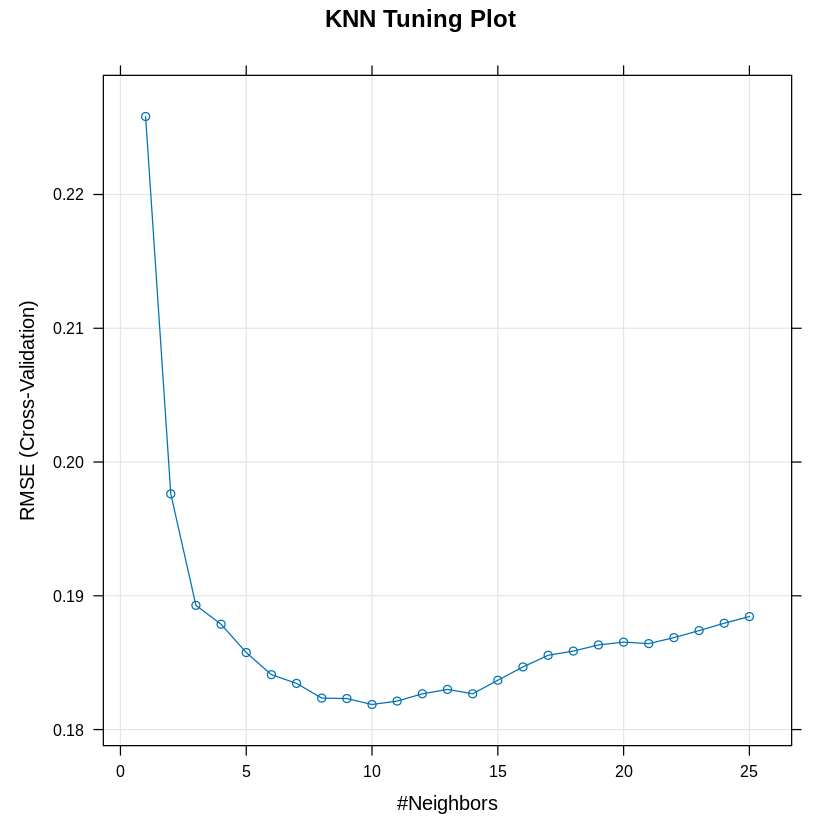

In [ ]:
# Load necessary libraries
library(caret)

# Define the tuning grid
set.seed(123)
knn_grid <- data.frame(.k = 1:25)  # Test k values from 1 to 20

# Train the KNN model
knn_model <- train(
  SalePrice ~ .,                  # Formula for regression
  data = train_models_with_corr,                # Filtered training data
  method = "knn",                 # KNN regression method
  preProcess = c("center", "scale"), # Standardize predictors
  tuneGrid = knn_grid,            # Tuning grid for k
  trControl = folds               # 10-fold cross-validation
)

# Output the tuned model results
print(knn_model)

# Plot the tuning results
plot(knn_model, main = "KNN Tuning Plot")

cat("Model Performance:\n")
cat("RMSE:", min(knn_model$results$RMSE), "\n")
cat("R-squared:", knn_model$results$Rsquared[which.min(knn_model$results$RMSE)], "\n")

# Save the model summary for later comparison
knn_model_summary <- knn_model$results

+ Fold01: size=1, decay=0.001 
- Fold01: size=1, decay=0.001 
+ Fold01: size=2, decay=0.001 
- Fold01: size=2, decay=0.001 
+ Fold01: size=3, decay=0.001 
- Fold01: size=3, decay=0.001 
+ Fold01: size=4, decay=0.001 
- Fold01: size=4, decay=0.001 
+ Fold01: size=5, decay=0.001 
- Fold01: size=5, decay=0.001 
+ Fold01: size=6, decay=0.001 
- Fold01: size=6, decay=0.001 
+ Fold01: size=7, decay=0.001 
- Fold01: size=7, decay=0.001 
+ Fold01: size=8, decay=0.001 
- Fold01: size=8, decay=0.001 
+ Fold01: size=1, decay=0.010 
- Fold01: size=1, decay=0.010 
+ Fold01: size=2, decay=0.010 
- Fold01: size=2, decay=0.010 
+ Fold01: size=3, decay=0.010 
- Fold01: size=3, decay=0.010 
+ Fold01: size=4, decay=0.010 
- Fold01: size=4, decay=0.010 
+ Fold01: size=5, decay=0.010 
- Fold01: size=5, decay=0.010 
+ Fold01: size=6, decay=0.010 
- Fold01: size=6, decay=0.010 
+ Fold01: size=7, decay=0.010 
- Fold01: size=7, decay=0.010 
+ Fold01: size=8, decay=0.010 
- Fold01: size=8, decay=0.010 
+ Fold01

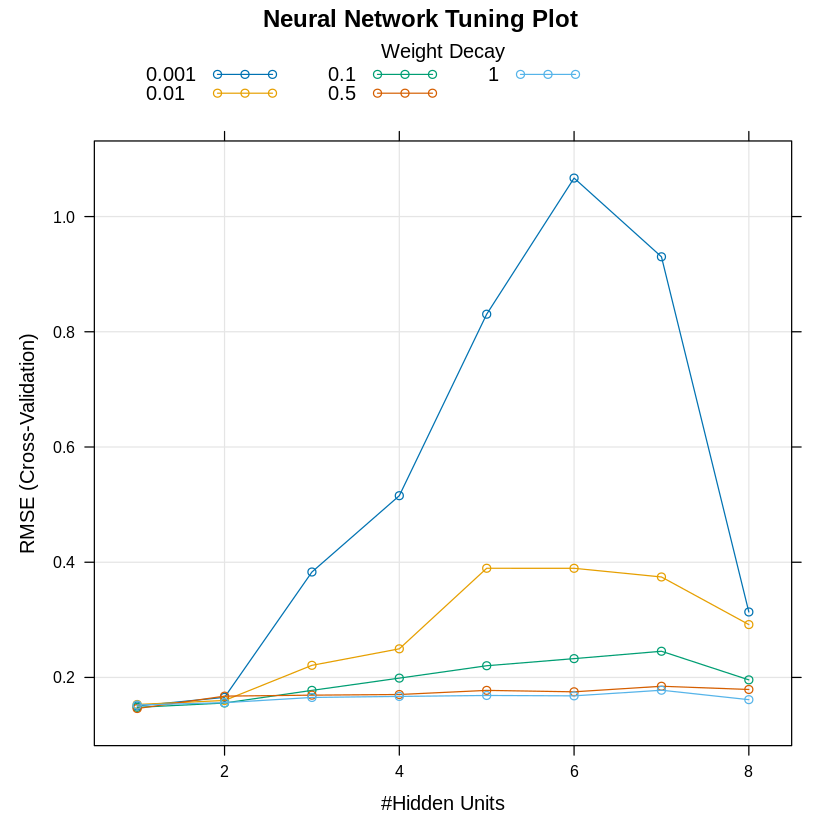

In [ ]:
# Define the tuning grid for neural networks
nnet_grid <- expand.grid(
  .size = c(1:8),   # Reduce hidden units to avoid overfitting
  .decay = c(0.001, 0.01, 0.1, 0.5, 1) # Increase regularization values
)

# Set weight limit
MaxNWts <- max(nnet_grid$.size) * (ncol(train_models_no_corr) + 1) +
  max(nnet_grid$.size) + 1

# Train the neural network model
set.seed(123)
nnet_model <- train(
  SalePrice ~ .,               # Formula specifying target and predictors
  data = train_models_no_corr,  # Training set
  method = "nnet",             # Neural network model
  tuneGrid = nnet_grid,        # Specify the tuning grid
  trControl = folds,           # 10-fold cross-validation
  preProcess = c("center", "scale"), # Standardize predictors
  linout = TRUE,               # Ensures output is linear (for regression)
  trace = FALSE,               # Suppress training details for readability
  MaxNWts = MaxNWts,           # Adjust weight limit
  maxit = 500                  # Increase training iterations
)

# Summarize the trained model
print(nnet_model)

# Plot tuning results
plot(nnet_model, main = "Neural Network Tuning Plot")

cat("Model Performance:\n")
cat("RMSE:", min(nnet_model$results$RMSE), "\n")
cat("R-squared:", nnet_model$results$Rsquared[which.min(nnet_model$results$RMSE)], "\n")

# Step 4: Save the Model Summary for Later Comparison
nnet_model_summary <- nnet_model$results

In [ ]:
install.packages("Metrics")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# Step 1: Prepare the Test Data (log-transform SalePrice for consistency)
test_models_no_corr <- cbind(test_set_no_corr, SalePrice = target_test)
#test_models_no_corr$SalePrice <- log1p(test_models_no_corr$SalePrice)
test_models_no_corr$SalePrice <- predict(boxcox_transformation_no_corr,
                                         test_models_no_corr[, "SalePrice", drop = FALSE])

test_models_with_corr <- cbind(test_set_with_corr, SalePrice = target_test)
#test_models_with_corr$SalePrice <- log1p(test_models_with_corr$SalePrice)
test_models_with_corr$SalePrice <- predict(boxcox_transformation_with_corr,
                                           test_models_with_corr[, "SalePrice", drop = FALSE])


In [ ]:
test_models_no_corr$SalePrice <- as.numeric(unlist(test_models_no_corr$SalePrice))
test_models_with_corr$SalePrice <- as.numeric(unlist(test_models_with_corr$SalePrice))

In [ ]:
skewness_no_corr_test <- skewness(test_models_no_corr$SalePrice)
skewness_with_corr_test <- skewness(test_models_with_corr$SalePrice)
cat("Skewness of SalePrice (Test, No Correlation):", skewness_no_corr_test, "\n")
cat("Skewness of SalePrice (Test, With Correlation):", skewness_with_corr_test, "\n")

Skewness of SalePrice (Test, No Correlation): -0.2194809 
Skewness of SalePrice (Test, With Correlation): -0.2194809 


In [ ]:
library(dplyr)

In [ ]:
test_data_no_target <- test_models_no_corr[, setdiff(names(test_models_no_corr), "SalePrice")]

# Make predictions
ols_predictions <- predict(ols_model, newdata = test_data_no_target)

# Calculate RMSE for OLS
ols_rmse <- sqrt(mean((test_models_no_corr$SalePrice - ols_predictions)^2))

# Calculate R-squared for OLS
ols_r_squared <- cor(test_models_no_corr$SalePrice, ols_predictions)^2

# Print Results
ols_rmse
ols_r_squared

[1] 0.1585287

[1] 0.8606519

In [ ]:
# OLS Model Predictions and Evaluation
#ols_predictions <- predict(ols_model, newdata = test_models_no_corr %>% select(-SalePrice))

# Calculate RMSE for OLS
#ols_rmse <- sqrt(mean((test_models_no_corr$SalePrice - ols_predictions)^2))

# Calculate R-squared for OLS
#ols_r_squared <- cor(test_models_no_corr$SalePrice, ols_predictions)^2

# Print Results
#ols_rmse
#ols_r_squared

In [ ]:
# Ridge Regression Predictions and Evaluation
#ridge_predictions <- predict(ridge_model, newdata = test_models_with_corr %>% select(-SalePrice))

# Calculate RMSE for Ridge
#ridge_rmse <- sqrt(mean((test_models_with_corr$SalePrice - ridge_predictions)^2))

# Calculate R-squared for Ridge
#ridge_r_squared <- cor(test_models_with_corr$SalePrice, ridge_predictions)^2

# Print Results
#ridge_rmse
#ridge_r_squared

In [ ]:
# Step 1: Remove SalePrice from predictors in the test set
test_data_with_corr_no_target <- test_models_with_corr[, setdiff(names(test_models_with_corr), "SalePrice")]

# Step 2: Make predictions using the Ridge model
ridge_predictions <- predict(ridge_model, newdata = test_data_with_corr_no_target)

# Step 3: Calculate RMSE for Ridge Regression
ridge_rmse <- sqrt(mean((test_models_with_corr$SalePrice - ridge_predictions)^2))

# Step 4: Calculate R-squared for Ridge Regression
ridge_r_squared <- cor(test_models_with_corr$SalePrice, ridge_predictions)^2

# Step 5: Print Results
cat("Ridge RMSE:", ridge_rmse, "\n")
cat("Ridge R-squared:", ridge_r_squared, "\n")

Ridge RMSE: 0.1521457 
Ridge R-squared: 0.870059 


In [ ]:
# Lasso Regression Predictions and Evaluation
#lasso_predictions <- predict(lasso_model, newdata = test_models_with_corr %>% select(-SalePrice))

# Calculate RMSE for Lasso
#lasso_rmse <- sqrt(mean((test_models_with_corr$SalePrice - lasso_predictions)^2))

# Calculate R-squared for Lasso
#lasso_r_squared <- cor(test_models_with_corr$SalePrice, lasso_predictions)^2

# Print Results
#lasso_rmse
#lasso_r_squared

In [ ]:
# Step 1: Remove SalePrice from predictors in the test set
test_data_with_corr_no_target <- test_models_with_corr[, setdiff(names(test_models_with_corr), "SalePrice")]

# Step 2: Make predictions using the Lasso model
lasso_predictions <- predict(lasso_model, newdata = test_data_with_corr_no_target)

# Step 3: Calculate RMSE for Lasso Regression
lasso_rmse <- sqrt(mean((test_models_with_corr$SalePrice - lasso_predictions)^2))

# Step 4: Calculate R-squared for Lasso Regression
lasso_r_squared <- cor(test_models_with_corr$SalePrice, lasso_predictions)^2

# Step 5: Print Results
cat("Lasso RMSE:", lasso_rmse, "\n")
cat("Lasso R-squared:", lasso_r_squared, "\n")

Lasso RMSE: 0.1532793 
Lasso R-squared: 0.8719271 


In [ ]:
# Elastic Net Predictions and Evaluation
#enet_predictions <- predict(enet_model, newdata = test_models_with_corr %>% select(-SalePrice))

# Calculate RMSE for Elastic Net
#enet_rmse <- sqrt(mean((test_models_with_corr$SalePrice - enet_predictions)^2))

# Calculate R-squared for Elastic Net
#enet_r_squared <- cor(test_models_with_corr$SalePrice, enet_predictions)^2

# Print Results
#enet_rmse
#enet_r_squared

In [ ]:
# Step 1: Remove SalePrice from predictors in the test set
test_data_with_corr_no_target <- test_models_with_corr[, setdiff(names(test_models_with_corr), "SalePrice")]

# Step 2: Make predictions using the Elastic Net model
enet_predictions <- predict(enet_model, newdata = test_data_with_corr_no_target)

# Step 3: Calculate RMSE for Elastic Net
enet_rmse <- sqrt(mean((test_models_with_corr$SalePrice - enet_predictions)^2))

# Step 4: Calculate R-squared for Elastic Net
enet_r_squared <- cor(test_models_with_corr$SalePrice, enet_predictions)^2

# Step 5: Print Results
cat("Elastic Net RMSE:", enet_rmse, "\n")
cat("Elastic Net R-squared:", enet_r_squared, "\n")

Elastic Net RMSE: 0.1512562 
Elastic Net R-squared: 0.8786557 


In [ ]:
# PCR Predictions and Evaluation
#pcr_predictions <- predict(pcr_model, newdata = test_models_with_corr %>% select(-SalePrice))

# Calculate RMSE for PCR
#pcr_rmse <- sqrt(mean((test_models_with_corr$SalePrice - pcr_predictions)^2))

# Calculate R-squared for PCR
#pcr_r_squared <- cor(test_models_with_corr$SalePrice, pcr_predictions)^2

# Print Results
#pcr_rmse
#pcr_r_squared

In [ ]:
# Step 1: Remove SalePrice from predictors in the test set
test_data_with_corr_no_target <- test_models_with_corr[, setdiff(names(test_models_with_corr), "SalePrice")]

# Step 2: Make predictions using the PCR model
pcr_predictions <- predict(pcr_model, newdata = test_data_with_corr_no_target)

# Step 3: Calculate RMSE for PCR
pcr_rmse <- sqrt(mean((test_models_with_corr$SalePrice - pcr_predictions)^2))

# Step 4: Calculate R-squared for PCR
pcr_r_squared <- cor(test_models_with_corr$SalePrice, pcr_predictions)^2

# Step 5: Print Results
cat("PCR RMSE:", pcr_rmse, "\n")
cat("PCR R-squared:", pcr_r_squared, "\n")

PCR RMSE: 0.1687404 
PCR R-squared: 0.8445183 


In [ ]:
# PLS Predictions and Evaluation
#pls_predictions <- predict(pls_model, newdata = test_models_with_corr %>% select(-SalePrice))

# Calculate RMSE for PLS
#pls_rmse <- sqrt(mean((test_models_with_corr$SalePrice - pls_predictions)^2))

# Calculate R-squared for PLS
#pls_r_squared <- cor(test_models_with_corr$SalePrice, pls_predictions)^2

# Print Results
#pls_rmse
#pls_r_squared

In [ ]:
# Step 1: Remove SalePrice from predictors in the test set
test_data_with_corr_no_target <- test_models_with_corr[, setdiff(names(test_models_with_corr), "SalePrice")]

# Step 2: Make predictions using the PLS model
pls_predictions <- predict(pls_model, newdata = test_data_with_corr_no_target)

# Step 3: Calculate RMSE for PLS
pls_rmse <- sqrt(mean((test_models_with_corr$SalePrice - pls_predictions)^2))

# Step 4: Calculate R-squared for PLS
pls_r_squared <- cor(test_models_with_corr$SalePrice, pls_predictions)^2

# Step 5: Print Results
cat("PLS RMSE:", pls_rmse, "\n")
cat("PLS R-squared:", pls_r_squared, "\n")

PLS RMSE: 0.1507725 
PLS R-squared: 0.8778174 


In [ ]:
# MARS Predictions and Evaluation
#mars_predictions <- predict(mars_model, newdata = test_models_with_corr %>% select(-SalePrice))

# Calculate RMSE for MARS
#mars_rmse <- sqrt(mean((test_models_with_corr$SalePrice - mars_predictions)^2))

# Calculate R-squared for MARS
#mars_r_squared <- cor(test_models_with_corr$SalePrice, mars_predictions)^2

# Print Results
#mars_rmse
#mars_r_squared

In [ ]:
# Step 1: Remove SalePrice from predictors in the test set
test_data_with_corr_no_target <- test_models_with_corr[, setdiff(names(test_models_with_corr), "SalePrice")]

# Step 2: Make predictions using the MARS model
mars_predictions <- predict(mars_model, newdata = test_data_with_corr_no_target)

# Step 3: Calculate RMSE for MARS
mars_rmse <- sqrt(mean((test_models_with_corr$SalePrice - mars_predictions)^2))

# Step 4: Calculate R-squared for MARS
mars_r_squared <- cor(test_models_with_corr$SalePrice, mars_predictions)^2

# Step 5: Print Results
cat("MARS RMSE:", mars_rmse, "\n")
cat("MARS R-squared:", mars_r_squared, "\n")

MARS RMSE: 0.1673047 
MARS R-squared: 0.843093 


In [ ]:
# SVM Predictions and Evaluation
#svm_predictions <- predict(svm_model, newdata = test_models_with_corr %>% select(-SalePrice))

# Calculate RMSE for SVM
#svm_rmse <- sqrt(mean((test_models_with_corr$SalePrice - svm_predictions)^2))

# Calculate R-squared for SVM
#svm_r_squared <- cor(test_models_with_corr$SalePrice, svm_predictions)^2

# Print Results
#svm_rmse
#svm_r_squared

[1] 0.1483339

[1] 0.8790848

In [ ]:
# Step 1: Remove SalePrice from predictors in the test set
test_data_with_corr_no_target <- test_models_with_corr[, setdiff(names(test_models_with_corr), "SalePrice")]

# Step 2: Make predictions using the SVM model
svm_predictions <- predict(svm_model, newdata = test_data_with_corr_no_target)

# Step 3: Calculate RMSE for SVM
svm_rmse <- sqrt(mean((test_models_with_corr$SalePrice - svm_predictions)^2))

# Step 4: Calculate R-squared for SVM
svm_r_squared <- cor(test_models_with_corr$SalePrice, svm_predictions)^2

# Step 5: Print Results
cat("SVM RMSE:", svm_rmse, "\n")
cat("SVM R-squared:", svm_r_squared, "\n")

SVM RMSE: 0.1460841 
SVM R-squared: 0.8828786 


In [ ]:
# KNN Predictions and Evaluation
#knn_predictions <- predict(knn_model, newdata = test_models_with_corr %>% select(-SalePrice))

# Calculate RMSE for KNN
#knn_rmse <- sqrt(mean((test_models_with_corr$SalePrice - knn_predictions)^2))

# Calculate R-squared for KNN
#knn_r_squared <- cor(test_models_with_corr$SalePrice, knn_predictions)^2

# Print Results
#knn_rmse
#knn_r_squared

In [ ]:
# Step 1: Remove SalePrice from predictors in the test set
test_data_with_corr_no_target <- test_models_with_corr[, setdiff(names(test_models_with_corr), "SalePrice")]

# Step 2: Make predictions using the KNN model
knn_predictions <- predict(knn_model, newdata = test_data_with_corr_no_target)

# Step 3: Calculate RMSE for KNN
knn_rmse <- sqrt(mean((test_models_with_corr$SalePrice - knn_predictions)^2))

# Step 4: Calculate R-squared for KNN
knn_r_squared <- cor(test_models_with_corr$SalePrice, knn_predictions)^2

# Step 5: Print Results
cat("KNN RMSE:", knn_rmse, "\n")
cat("KNN R-squared:", knn_r_squared, "\n")

KNN RMSE: 0.1907653 
KNN R-squared: 0.8181342 


In [ ]:
# Neural Network Predictions and Evaluation
#nnet_predictions <- predict(nnet_model, newdata = test_models_no_corr %>% select(-SalePrice))

# Calculate RMSE for Neural Network
#nnet_rmse <- sqrt(mean((test_models_no_corr$SalePrice - nnet_predictions)^2))

# Calculate R-squared for Neural Network
#nnet_r_squared <- cor(test_models_no_corr$SalePrice, nnet_predictions)^2

# Print Results
#nnet_rmse
#nnet_r_squared

In [ ]:
# Step 1: Remove SalePrice from predictors in the test set
test_data_no_corr_no_target <- test_models_no_corr[, setdiff(names(test_models_no_corr), "SalePrice")]

# Step 2: Make predictions using the Neural Network model
nnet_predictions <- predict(nnet_model, newdata = test_data_no_corr_no_target)

# Step 3: Calculate RMSE for Neural Network
nnet_rmse <- sqrt(mean((test_models_no_corr$SalePrice - nnet_predictions)^2))

# Step 4: Calculate R-squared for Neural Network
nnet_r_squared <- cor(test_models_no_corr$SalePrice, nnet_predictions)^2

# Step 5: Print Results
cat("Neural Network RMSE:", nnet_rmse, "\n")
cat("Neural Network R-squared:", nnet_r_squared, "\n")

Neural Network RMSE: 0.1437893 
Neural Network R-squared: 0.8855455 


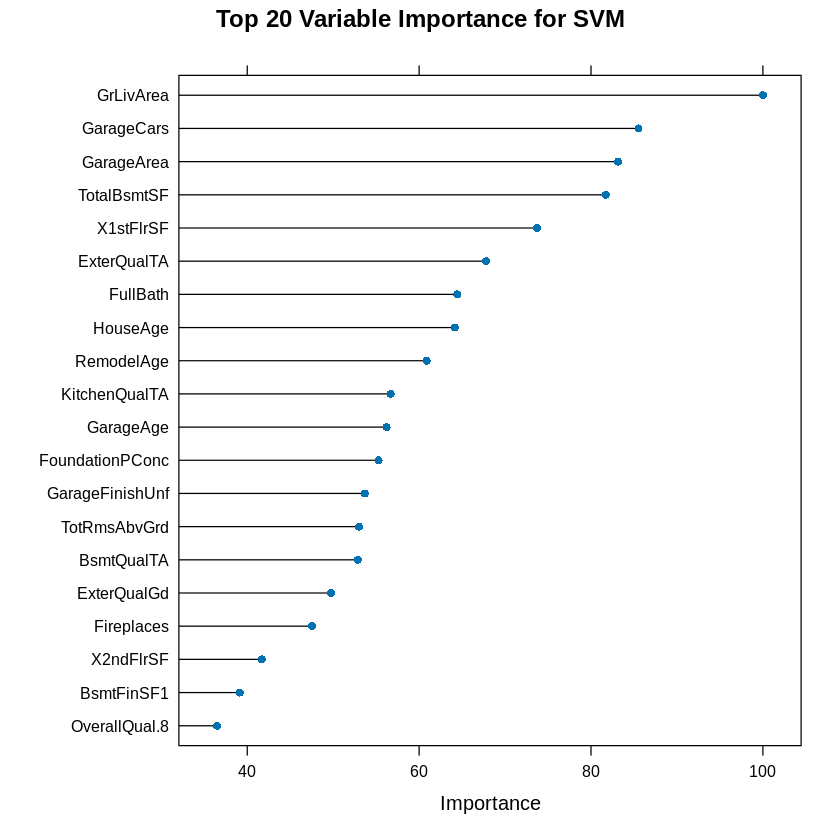

In [ ]:
# Calculate variable importance for SVM
svm_varimp <- varImp(svm_model)

# Plot the importance
plot(svm_varimp, top = 20, main = "Top 20 Variable Importance for SVM")

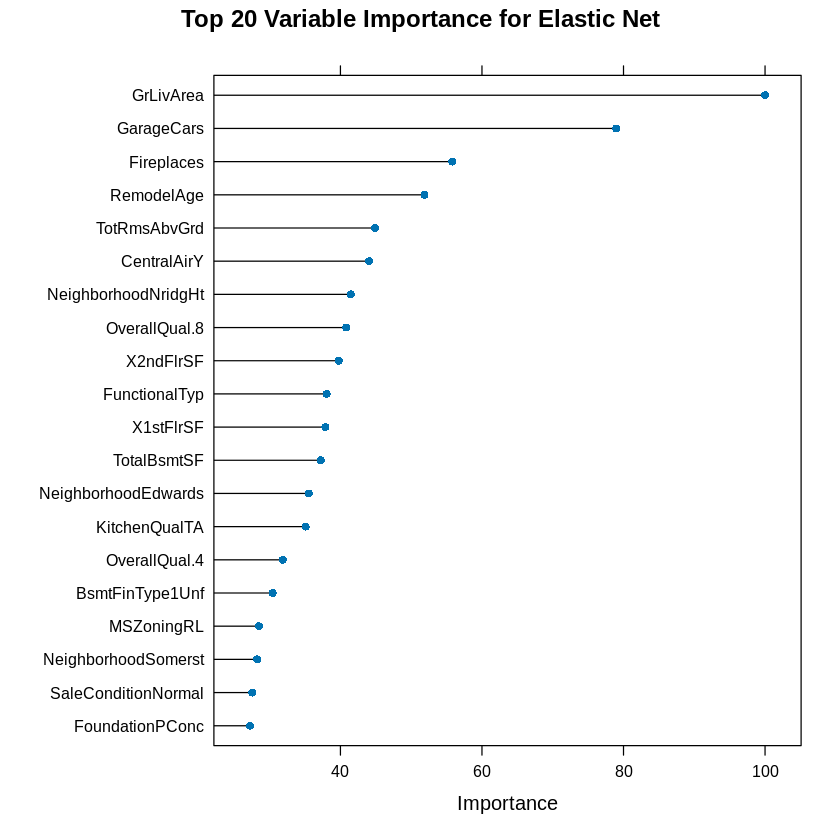

In [ ]:
# Calculate variable importance for Elastic Net
enet_varimp <- varImp(enet_model)

# Plot the importance
plot(enet_varimp, top = 20, main = "Top 20 Variable Importance for Elastic Net")

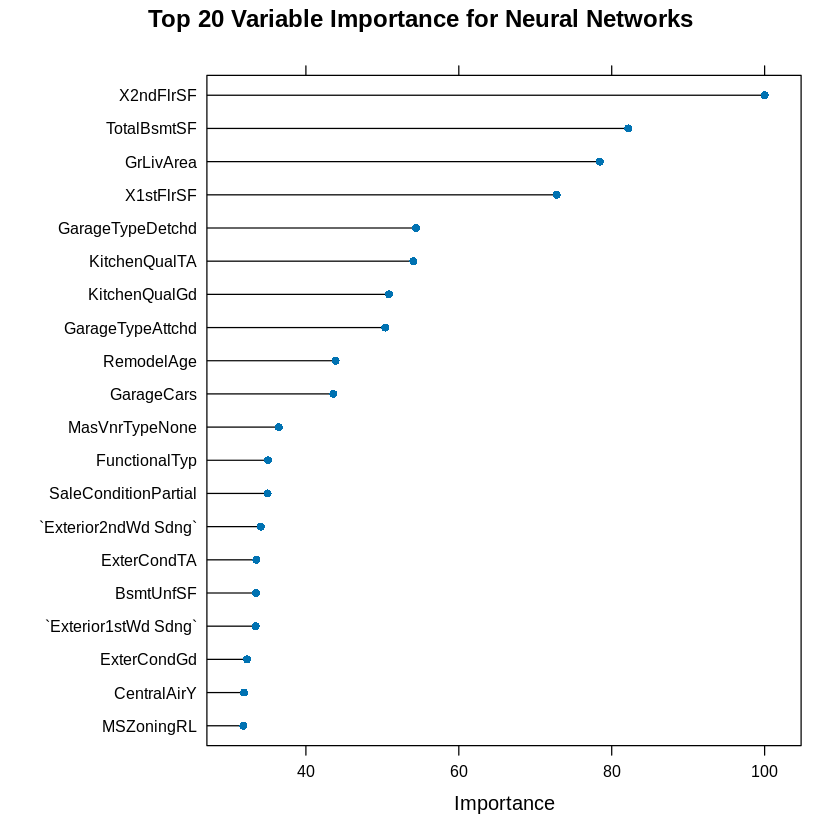

In [ ]:
# Calculate variable importance for Elastic Net
nnet_vatimp <- varImp(nnet_model)

# Plot the importance
plot(nnet_vatimp, top = 20, main = "Top 20 Variable Importance for Neural Networks")